# FBE599, Final Project
# Topic: A Machine Learning View on Reversal Strategy
## Group member: 
### Lu Liu
### Haoyang Luo
### Wanyi Chen
### Bingqing Wei


# Description: 
### We have learned that reversal is a successful trading strategy even if we consider trading costs. The strategy itself is relatively simple, go long on stocks that have been yielding low returns for a period of time and go short on stocks that have been yielding high returns. 
### We believed that with some enhancements, we would be able to optimize this strategy by buying and selling those we predict will revert. We used crsp dataset downloaded from Wharton Data Research Service, the original dataset contains the basic price and volume information. 
### In order to test the predictability of past price and volume, we created multiple lag variables. To build a robust prediction model, we used multiple machine learning models, which includes OLS regression, LASSO, Ridge regression, SVR, and Elastic Net. 
### We trained our data and made predictions using each model, then took the average of predictions from each model. The results show that our strategy significantly improves the standard reversal strategy. However, we did not consider transaction cost in our research. The purpose of our research is just to provide another approach to optimize the reversal strategy. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import risk-free return
rf = pd.read_csv('^IRX.csv',parse_dates = [0], index_col = [0])
rf['rf'] = rf['Close'].fillna(method ='pad',limit =3)/100
rf = rf['rf']

In [3]:
# select stock data from year 2016 - 2018
df = pd.read_csv('stocks.csv', parse_dates = [1])
stocks = df.set_index(['PERMNO','date'])
stocks.head()

SHRCD TICKER           COMNAM  DIVAMT  BIDLO  ASKHI   PRC  \
PERMNO date                                                                    
10001  2016-01-04     11   EGAS  GAS NATURAL INC     NaN   7.44   7.59  7.52   
       2016-01-05     11   EGAS  GAS NATURAL INC     NaN   7.31   7.58  7.42   
       2016-01-06     11   EGAS  GAS NATURAL INC     NaN   7.25   7.55  7.53   
       2016-01-07     11   EGAS  GAS NATURAL INC     NaN   7.30   7.69  7.64   
       2016-01-08     11   EGAS  GAS NATURAL INC     NaN   7.59   7.79  7.79   

                       VOL    RET   BID   ASK   SHROUT  OPENPRC  NUMTRD  \
PERMNO date                                                               
10001  2016-01-04  15816.0   0.01  7.52  7.58  10505.0     7.44     NaN   
       2016-01-05  22037.0  -0.01  7.36  7.40  10505.0     7.49     NaN   
       2016-01-06  11532.0   0.01  7.48  7.55  10505.0     7.39     NaN   
       2016-01-07  17172.0   0.01  7.65  7.70  10505.0     7.51     NaN   
       2016-01-08   9622.0   0.02  7.73  7.78  10505.0     7.62     NaN   

                    RETX  vwretd  
PERMNO date                       
10001  2016-01-04   0.01   -0.01  
       2016-01-05  -0.01    0.00  
       2016-01-06   0.01   -0.01  
       2016-01-07   0.01   -0.02  
       2016-01-08   0.02   -0.01

In [4]:
# check missing value
stocks.isna().sum()

SHRCD            0
TICKER        1030
COMNAM           0
DIVAMT     1043634
BIDLO         2288
ASKHI         2288
PRC           2288
VOL           2287
RET           1258
BID           2279
ASK           2301
SHROUT         261
OPENPRC      22435
NUMTRD      390538
RETX          1258
vwretd           0
dtype: int64

In [5]:
# fill part of missing value
stocks['PRC'] = abs(stocks['PRC'])
stocks['PRC'] = stocks['PRC'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['BID'] = stocks['BID'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['ASK'] = stocks['ASK'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['VOL'] = stocks['VOL'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['RET'] = stocks['RET'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['OPENPRC'] = stocks['OPENPRC'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['SHROUT'] = stocks['SHROUT'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['BIDLO'] = stocks['BIDLO'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks['ASKHI'] = stocks['ASKHI'].groupby('PERMNO').fillna(method ='pad',limit =3)
stocks.isna().sum()

SHRCD            0
TICKER        1030
COMNAM           0
DIVAMT     1043634
BIDLO         1675
ASKHI         1675
PRC           1675
VOL           1675
RET            651
BID           1679
ASK           1687
SHROUT           7
OPENPRC       7319
NUMTRD      390538
RETX          1258
vwretd           0
dtype: int64

In [6]:
stocks.drop(columns = {'DIVAMT','NUMTRD','TICKER','RETX'}, axis = 1,inplace = True)

In [7]:
stocks.dropna(inplace = True)
stocks.head()

SHRCD           COMNAM  BIDLO  ASKHI   PRC      VOL    RET  \
PERMNO date                                                                     
10001  2016-01-04     11  GAS NATURAL INC   7.44   7.59  7.52  15816.0   0.01   
       2016-01-05     11  GAS NATURAL INC   7.31   7.58  7.42  22037.0  -0.01   
       2016-01-06     11  GAS NATURAL INC   7.25   7.55  7.53  11532.0   0.01   
       2016-01-07     11  GAS NATURAL INC   7.30   7.69  7.64  17172.0   0.01   
       2016-01-08     11  GAS NATURAL INC   7.59   7.79  7.79   9622.0   0.02   

                    BID   ASK   SHROUT  OPENPRC  vwretd  
PERMNO date                                              
10001  2016-01-04  7.52  7.58  10505.0     7.44   -0.01  
       2016-01-05  7.36  7.40  10505.0     7.49    0.00  
       2016-01-06  7.48  7.55  10505.0     7.39   -0.01  
       2016-01-07  7.65  7.70  10505.0     7.51   -0.02  
       2016-01-08  7.73  7.78  10505.0     7.62   -0.01

## Create New Features

In [8]:
stocks['TurnOver'] = stocks['VOL']/stocks['SHROUT']

In [9]:
stocks['RET'] = pd.to_numeric(stocks['RET'],errors = 'coerce')
stocks.dropna(inplace = True)

In [10]:
stocks['ob_vola5'] = stocks.groupby('PERMNO')['RET'].shift(1).rolling(5).std()
stocks['ob_vola10'] = stocks.groupby('PERMNO')['RET'].shift(1).rolling(10).std()
stocks['ob_vola15'] = stocks.groupby('PERMNO')['RET'].shift(1).rolling(15).std()
stocks['ob_vola20'] = stocks.groupby('PERMNO')['RET'].shift(1).rolling(20).std()

In [11]:
stocks['ob_diff'] = stocks.groupby('PERMNO')['PRC'].shift(5) - stocks.groupby('PERMNO')['PRC'].shift(10)

In [12]:
stocks['lag5_ret'] = stocks.groupby('PERMNO')['RET'].shift(5)
stocks['lag4_ret'] = stocks.groupby('PERMNO')['RET'].shift(4)
stocks['lag3_ret'] = stocks.groupby('PERMNO')['RET'].shift(3)
stocks['lag2_ret'] = stocks.groupby('PERMNO')['RET'].shift(2)
stocks['lag1_ret'] = stocks.groupby('PERMNO')['RET'].shift(1)
stocks['lag5_TO'] = stocks.groupby('PERMNO')['TurnOver'].shift(5)
stocks['lag4_TO'] = stocks.groupby('PERMNO')['TurnOver'].shift(4)
stocks['lag3_TO'] = stocks.groupby('PERMNO')['TurnOver'].shift(3)
stocks['lag2_TO'] = stocks.groupby('PERMNO')['TurnOver'].shift(2)
stocks['lag1_TO'] = stocks.groupby('PERMNO')['TurnOver'].shift(1)
stocks['Market_Cap'] = stocks['SHROUT'] * stocks['PRC']
stocks['lag_BIDLO']= stocks.groupby('PERMNO')['BIDLO'].shift()
stocks['lag_ASKHI']= stocks.groupby('PERMNO')['ASKHI'].shift()
stocks['lag_PRC']= stocks.groupby('PERMNO')['PRC'].shift()
stocks['lag_BID']= stocks.groupby('PERMNO')['BID'].shift()
stocks['lag_ASK'] = stocks.groupby('PERMNO')['ASK'].shift()
stocks['lag_vwretd'] = stocks.groupby('PERMNO')['vwretd'].shift()

In [13]:
stocks.drop(['COMNAM','SHRCD','VOL','BIDLO', 'ASKHI', 'PRC','BID', 'ASK','SHROUT','vwretd','TurnOver'], axis = 1,inplace = True)

In [14]:
# selected features
stocks.columns

Index(['RET', 'OPENPRC', 'ob_vola5', 'ob_vola10', 'ob_vola15', 'ob_vola20',
       'ob_diff', 'lag5_ret', 'lag4_ret', 'lag3_ret', 'lag2_ret', 'lag1_ret',
       'lag5_TO', 'lag4_TO', 'lag3_TO', 'lag2_TO', 'lag1_TO', 'Market_Cap',
       'lag_BIDLO', 'lag_ASKHI', 'lag_PRC', 'lag_BID', 'lag_ASK',
       'lag_vwretd'],
      dtype='object')

In [15]:
stocks.dropna(inplace = True)

In [16]:
stocks.head()

RET  OPENPRC  ob_vola5  ob_vola10  ob_vola15  ob_vola20  \
PERMNO date                                                                   
10001  2016-02-02  0.01     8.39  0.004472   0.013499   0.015492   0.014327   
       2016-02-03 -0.03     8.47  0.004472   0.012517   0.013870   0.014327   
       2016-02-04 -0.03     8.25  0.017321   0.016330   0.015337   0.016026   
       2016-02-05  0.04     8.05  0.021909   0.018886   0.017099   0.017652   
       2016-02-08  0.03     8.32  0.030000   0.023094   0.020166   0.019541   

                   ob_diff  lag5_ret  lag4_ret  lag3_ret  ...   lag3_TO  \
PERMNO date                                               ...             
10001  2016-02-02    -0.02      0.01      0.01      0.00  ...  0.905664   
       2016-02-03     0.12      0.01      0.00      0.01  ...  1.060162   
       2016-02-04     0.10      0.00      0.01      0.01  ...  0.429510   
       2016-02-05     0.10      0.01      0.01      0.01  ...  0.273203   
       2016-02-08     0.42      0.01      0.01     -0.03  ...  0.435983   

                    lag2_TO   lag1_TO  Market_Cap  lag_BIDLO  lag_ASKHI  \
PERMNO date                                                               
10001  2016-02-02  1.060162  0.429510    89187.45       8.12       8.50   
       2016-02-03  0.429510  0.273203    86771.30       8.21       8.49   
       2016-02-04  0.273203  0.435983    84040.00       8.14       8.49   
       2016-02-05  0.435983  1.116897    87611.70       8.00       8.29   
       2016-02-08  1.116897  2.946502    90658.15       7.85       8.44   

                   lag_PRC  lag_BID  lag_ASK  lag_vwretd  
PERMNO date                                               
10001  2016-02-02     8.42     8.42     8.49        0.00  
       2016-02-03     8.49     8.36     8.49       -0.02  
       2016-02-04     8.26     8.14     8.30        0.01  
       2016-02-05     8.00     8.01     8.06        0.00  
       2016-02-08     8.34     8.24     8.39       -0.02  

[5 rows x 24 columns]

# Run Machine Model

In [17]:
model_stocks = stocks.copy()
model_stocks = model_stocks.reset_index()

In [18]:
date_name = pd.Series(model_stocks['date'].unique()).tolist()
date_name[:5]

[Timestamp('2016-02-02 00:00:00'),
 Timestamp('2016-02-03 00:00:00'),
 Timestamp('2016-02-04 00:00:00'),
 Timestamp('2016-02-05 00:00:00'),
 Timestamp('2016-02-08 00:00:00')]

In [19]:
model_stocks = model_stocks.set_index(['date','PERMNO'])
model_stocks.sort_index(inplace = True)

In [20]:
model_stocks.head()

RET  OPENPRC  ob_vola5  ob_vola10  ob_vola15  ob_vola20  \
date       PERMNO                                                             
2016-02-02 10001   0.01     8.39  0.004472   0.013499   0.015492   0.014327   
           10025  -0.01    82.21  0.047749   0.057937   0.052671   0.048933   
           10026  -0.02   106.68  0.014142   0.013703   0.015213   0.015035   
           10028  -0.02     0.38  0.091269   0.090578   0.076799   0.072989   
           10032  -0.03    34.19  0.020736   0.044272   0.039243   0.035314   

                   ob_diff  lag5_ret  lag4_ret  lag3_ret  ...   lag3_TO  \
date       PERMNO                                         ...             
2016-02-02 10001     -0.02      0.01      0.01      0.00  ...  0.905664   
           10025      9.01      0.08     -0.02     -0.02  ...  3.698021   
           10026     -2.50     -0.01     -0.01      0.01  ...  3.816280   
           10028      0.02      0.22      0.01      0.04  ...  1.194941   
           10032      5.27      0.03     -0.02      0.00  ...  4.066504   

                    lag2_TO   lag1_TO  Market_Cap  lag_BIDLO  lag_ASKHI  \
date       PERMNO                                                         
2016-02-02 10001   1.060162  0.429510    89187.45       8.12       8.50   
           10025   8.621304  4.874486   421889.27      81.56      85.20   
           10026   4.925452  2.938189  1965767.20     107.07     108.69   
           10028   2.161028  0.090273     4795.44       0.37       0.40   
           10032   9.590486  2.852957  1127058.12      34.29      34.93   

                   lag_PRC  lag_BID  lag_ASK  lag_vwretd  
date       PERMNO                                         
2016-02-02 10001      8.42     8.42     8.49         0.0  
           10025     83.20    83.13    83.42         0.0  
           10026    107.13   107.08   107.18         0.0  
           10028      0.40     0.40     0.42         0.0  
           10032     34.75    34.72    34.75         0.0  

[5 rows x 24 columns]

In [21]:
# feature scale
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scale_X = min_max_scaler.fit_transform(model_stocks.iloc[:,1:])
scale_X = pd.DataFrame(scale_X.tolist(), columns = model_stocks.iloc[:,1:].columns, index = model_stocks.index )

In [22]:
scale_X.head()

OPENPRC  ob_vola5  ob_vola10  ob_vola15  ob_vola20  \
date       PERMNO                                                        
2016-02-02 10001   0.000025  0.001387   0.005916   0.008314   0.008881   
           10025   0.000245  0.014808   0.025392   0.028268   0.030332   
           10026   0.000319  0.004386   0.006006   0.008164   0.009320   
           10028   0.000001  0.028305   0.039698   0.041216   0.045244   
           10032   0.000102  0.006431   0.019403   0.021061   0.021890   

                    ob_diff  lag5_ret  lag4_ret  lag3_ret  lag2_ret  ...  \
date       PERMNO                                                    ...   
2016-02-02 10001   0.604138  0.115479  0.115479  0.114251  0.115479  ...   
           10025   0.604282  0.124079  0.111794  0.111794  0.120393  ...   
           10026   0.604098  0.113022  0.113022  0.115479  0.116708  ...   
           10028   0.604138  0.141278  0.115479  0.119165  0.127764  ...   
           10032   0.604222  0.117936  0.111794  0.114251  0.116708  ...   

                    lag3_TO   lag2_TO   lag1_TO  Market_Cap  lag_BIDLO  \
date       PERMNO                                                        
2016-02-02 10001   0.000036  0.000042  0.000017    0.000081   0.000024   
           10025   0.000147  0.000344  0.000194    0.000382   0.000245   
           10026   0.000152  0.000196  0.000117    0.001781   0.000322   
           10028   0.000048  0.000086  0.000004    0.000004   0.000001   
           10032   0.000162  0.000382  0.000114    0.001021   0.000103   

                   lag_ASKHI   lag_PRC   lag_BID   lag_ASK  lag_vwretd  
date       PERMNO                                                       
2016-02-02 10001    0.000025  0.000025  0.000025  0.000025    0.444444  
           10025    0.000253  0.000248  0.000248  0.000248    0.444444  
           10026    0.000323  0.000319  0.000319  0.000319    0.444444  
           10028    0.000001  0.000001  0.000001  0.000001    0.444444  
           10032    0.000104  0.000103  0.000103  0.000103    0.444444  

[5 rows x 23 columns]

## 1. Linear Regression Model

In [23]:
prediction = pd.DataFrame(columns = {'date'})

In [24]:
import statsmodels.api as sm
for s in range(10, len(date_name)):
    regdata = model_stocks.loc[date_name[s-10]:date_name[s]]
    regX = scale_X.loc[date_name[s-10]:date_name[s]]
    Y = regdata['RET']
    X = sm.add_constant(regX)
    results = sm.OLS(Y,X).fit()
    a = pd.DataFrame(results.predict(X.loc[date_name[s]]),columns = {'lr_return'})
    a['date'] = date_name[s]
    prediction = pd.concat([prediction,a],axis = 0)    

## 2. LASSO Model

In [25]:
from sklearn.linear_model import Lasso, LassoLarsIC, LassoLarsCV

In [26]:
def lasso_regression(Y, X, alpha):
    
    #concatenating the X and Y variables and eliminating rows where the Y variable is missing
    YX = pd.concat([Y, X], axis=1).dropna(subset=[Y.columns[0]]);

    # if there is not enough data left, we stop the function now
    # if YX.shape[0]<minpers:
    #     return np.nan
  
    # now we extract the X and Y columns from the concatenated XY dataframe
    Y  = YX.iloc[:,0]
    X  = YX.iloc[:,1:]
    
    # eliminating columns in the independent variables for which there are any missing values
    X = X.dropna(axis=1)
       
    # there are four different ways to choose alpha
    if alpha=='aic':
       # using the Akaike Information Criterion to determine the lasso penalty parameter alpha
       lassoreg = LassoLarsIC(criterion='aic', normalize=True, max_iter=1e5)
    elif alpha=='bic':
       # using the Bayesian Information Criterion to determine the lasso penalty parameter alpha
       lassoreg = LassoLarsIC(criterion='bic', normalize=True, max_iter=1e5)
    elif alpha=='cv':
       # using 5-fold cross validation to determine the lasso penalty parameter alpha
       lassoreg = LassoLarsCV(normalize=True, max_iter=1e5, cv=5)
    else:
       # using a pre-set numerical value for alpha
       lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    
    # returning the lasso estimates    
    return lassoreg.fit(X,Y)

In [27]:
lasso_pred = pd.DataFrame(columns = {'LASSO_return'})
for s in range(10, len(date_name)):
    regdata = model_stocks.loc[date_name[s-10]:date_name[s]]
    regX = scale_X.loc[date_name[s-10]:date_name[s]]
    Y = regdata['RET']
    results = lasso_regression(regX, Y, 'cv')
    temp = regX.loc[date_name[s]]
    id_name = temp.index.get_level_values('PERMNO').tolist()
    a = pd.DataFrame(results.predict(regX.loc[date_name[s]]),columns = {'LASSO_return'},index = id_name)
    lasso_pred = pd.concat([lasso_pred,a],axis = 0) 

In [28]:
prediction = pd.concat([prediction,lasso_pred],axis = 1) 

## 3. Ridge Model

In [29]:
from sklearn.linear_model import Ridge
ridge_pred = pd.DataFrame(columns = {'Ridge_return'})
for s in range(10, len(date_name)):
    regdata = model_stocks.loc[date_name[s-10]:date_name[s]]
    regX = scale_X.loc[date_name[s-10]:date_name[s]]
    Y = regdata['RET']
    ridge = Ridge()
    results = ridge.fit(regX, Y)  
    temp = regX.loc[date_name[s]]
    id_name = temp.index.get_level_values('PERMNO').tolist()
    a = pd.DataFrame(results.predict(regX.loc[date_name[s]]),columns = {'Ridge_return'},index = id_name)
    ridge_pred = pd.concat([ridge_pred,a],axis = 0) 

In [30]:
prediction = pd.concat([prediction,ridge_pred],axis = 1) 

## 4. SVR Model

In [31]:
from sklearn.svm import SVR
svr_pred = pd.DataFrame(columns = {'SVR_return'})
for s in range(10, len(date_name)):
    regdata = model_stocks.loc[date_name[s-10]:date_name[s]]
    regX = scale_X.loc[date_name[s-10]:date_name[s]]
    Y = regdata['RET']
    svr = SVR(kernel='rbf')
    results = svr.fit(regX, Y)  
    temp = regX.loc[date_name[s]]
    id_name = temp.index.get_level_values('PERMNO').tolist()
    a = pd.DataFrame(results.predict(regX.loc[date_name[s]]),columns = {'SVR_return'},index = id_name)
    svr_pred = pd.concat([svr_pred,a],axis = 0) 


In [32]:
prediction = pd.concat([prediction,svr_pred],axis = 1) 

## 5. Elastic Net Model 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [34]:
# This model is very slow, it may take 20 minutes to run
elastic_pred = pd.DataFrame(columns = {'Elastic_return'})
for s in range(10, len(date_name)):
    regdata = model_stocks.loc[date_name[s-10]:date_name[s]]
    regX = scale_X.loc[date_name[s-10]:date_name[s]]
    Y = regdata['RET']
    elastic = ElasticNet(normalize=True)
    search = GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),
                                                  'l1_ratio':[.2,.4,.6,.8]},
                                                scoring='neg_mean_squared_error',
                                                n_jobs=1, refit=True,cv=10)
    search1 = search.fit(regX,Y)
    params = search1.best_params_
    elastic = ElasticNet(normalize=True, alpha = params['alpha'],l1_ratio = params['l1_ratio'])
    results = elastic.fit(regX, Y)  
    temp = regX.loc[date_name[s]]
    id_name = temp.index.get_level_values('PERMNO').tolist()
    a = pd.DataFrame(results.predict(regX.loc[date_name[s]]),columns = {'Elastic_return'},index = id_name)
    elastic_pred = pd.concat([elastic_pred,a],axis = 0) 



In [35]:
prediction = pd.concat([prediction,elastic_pred],axis = 1) 

## We decided to use the average of each model's predictions as our final prediction 

In [36]:
prediction.index.names = ['PERMNO']
prediction['pred_return'] = prediction.iloc[:,1:].mean(axis = 1)
prediction.head()

,date,lr_return,LASSO_return,Ridge_return,SVR_return,Elastic_return,pred_return
PERMNO,,,,,,,
10001,2016-02-17,0.017942,0.018541,0.016049,0.022361,0.015593,0.018098
10025,2016-02-17,0.005972,0.018275,0.011431,0.022022,0.004554,0.012451
10026,2016-02-17,0.013379,0.019071,0.014912,0.022350,0.012083,0.016359
10028,2016-02-17,-0.004037,0.017298,0.007463,0.021703,-0.003830,0.007719
10032,2016-02-17,0.014164,0.018422,0.014304,0.022256,0.010747,0.015979


In [37]:
pred = prediction.copy()
pred = pred.reset_index()
pred = pred.set_index(['date','PERMNO'])
pred.sort_index(inplace = True)
pred.head()

lr_return  LASSO_return  Ridge_return  SVR_return  \
date       PERMNO                                                      
2016-02-17 10001    0.017942      0.018541      0.016049    0.022361   
           10025    0.005972      0.018275      0.011431    0.022022   
           10026    0.013379      0.019071      0.014912    0.022350   
           10028   -0.004037      0.017298      0.007463    0.021703   
           10032    0.014164      0.018422      0.014304    0.022256   

                   Elastic_return  pred_return  
date       PERMNO                               
2016-02-17 10001         0.015593     0.018098  
           10025         0.004554     0.012451  
           10026         0.012083     0.016359  
           10028        -0.003830     0.007719  
           10032         0.010747     0.015979

## Because some dates are dropped in previous steps, we decided to calculate 5 days moving average from the orginal dataset

In [38]:
model_stocks2 = stocks.copy()
model_stocks2['5d_mean_ret'] = stocks.groupby('PERMNO')['RET'].shift(1).rolling(5).mean()

In [39]:
model_stocks2.head()

RET  OPENPRC  ob_vola5  ob_vola10  ob_vola15  ob_vola20  \
PERMNO date                                                                   
10001  2016-02-02  0.01     8.39  0.004472   0.013499   0.015492   0.014327   
       2016-02-03 -0.03     8.47  0.004472   0.012517   0.013870   0.014327   
       2016-02-04 -0.03     8.25  0.017321   0.016330   0.015337   0.016026   
       2016-02-05  0.04     8.05  0.021909   0.018886   0.017099   0.017652   
       2016-02-08  0.03     8.32  0.030000   0.023094   0.020166   0.019541   

                   ob_diff  lag5_ret  lag4_ret  lag3_ret  ...   lag2_TO  \
PERMNO date                                               ...             
10001  2016-02-02    -0.02      0.01      0.01      0.00  ...  1.060162   
       2016-02-03     0.12      0.01      0.00      0.01  ...  0.429510   
       2016-02-04     0.10      0.00      0.01      0.01  ...  0.273203   
       2016-02-05     0.10      0.01      0.01      0.01  ...  0.435983   
       2016-02-08     0.42      0.01      0.01     -0.03  ...  1.116897   

                    lag1_TO  Market_Cap  lag_BIDLO  lag_ASKHI  lag_PRC  \
PERMNO date                                                              
10001  2016-02-02  0.429510    89187.45       8.12       8.50     8.42   
       2016-02-03  0.273203    86771.30       8.21       8.49     8.49   
       2016-02-04  0.435983    84040.00       8.14       8.49     8.26   
       2016-02-05  1.116897    87611.70       8.00       8.29     8.00   
       2016-02-08  2.946502    90658.15       7.85       8.44     8.34   

                   lag_BID  lag_ASK  lag_vwretd  5d_mean_ret  
PERMNO date                                                   
10001  2016-02-02     8.42     8.49        0.00          NaN  
       2016-02-03     8.36     8.49       -0.02          NaN  
       2016-02-04     8.14     8.30        0.01          NaN  
       2016-02-05     8.01     8.06        0.00          NaN  
       2016-02-08     8.24     8.39       -0.02          NaN  

[5 rows x 25 columns]

In [40]:
# add risk-free rate in the dataframe
ret = model_stocks2[['RET','lag1_ret','5d_mean_ret']]
ret.dropna(inplace = True)
ret_temp = ret.copy()
ret_temp = ret_temp.reset_index()
ret_temp.index = ret_temp['date']
ret_temp = ret_temp.merge(rf, how = 'left', left_index = True, right_index = True)
ret_temp.head()

,PERMNO,date,RET,lag1_ret,5d_mean_ret,rf
2016-02-09,10001,2016-02-09,-0.05,0.03,0.004,0.003
2016-02-09,10025,2016-02-09,0.06,0.00,-0.020,0.003
2016-02-09,10026,2016-02-09,0.00,0.00,-0.004,0.003
2016-02-09,10028,2016-02-09,0.16,0.19,0.050,0.003
2016-02-09,10032,2016-02-09,0.02,0.01,-0.006,0.003


In [41]:
ret1 = ret_temp.copy()
ret1 = ret1.set_index(['date','PERMNO'])
ret1.sort_index(inplace = True)
ret1['EX_ret'] = ret1['RET']-ret1['rf']
ret1.head()

RET  lag1_ret  5d_mean_ret     rf  EX_ret
date       PERMNO                                            
2016-02-09 10001  -0.05      0.03        0.004  0.003  -0.053
           10025   0.06      0.00       -0.020  0.003   0.057
           10026   0.00      0.00       -0.004  0.003  -0.003
           10028   0.16      0.19        0.050  0.003   0.157
           10032   0.02      0.01       -0.006  0.003   0.017

In [42]:
result = pred.merge(ret1, how = 'left', left_index = True, right_index = True)
result.head()

lr_return  LASSO_return  Ridge_return  SVR_return  \
date       PERMNO                                                      
2016-02-17 10001    0.017942      0.018541      0.016049    0.022361   
           10025    0.005972      0.018275      0.011431    0.022022   
           10026    0.013379      0.019071      0.014912    0.022350   
           10028   -0.004037      0.017298      0.007463    0.021703   
           10032    0.014164      0.018422      0.014304    0.022256   

                   Elastic_return  pred_return   RET  lag1_ret  5d_mean_ret  \
date       PERMNO                                                             
2016-02-17 10001         0.015593     0.018098 -0.01     -0.01       -0.010   
           10025         0.004554     0.012451 -0.02     -0.01        0.002   
           10026         0.012083     0.016359 -0.01      0.01        0.008   
           10028        -0.003830     0.007719  0.00      0.07        0.046   
           10032         0.010747     0.015979  0.01      0.03        0.012   

                        rf   EX_ret  
date       PERMNO                    
2016-02-17 10001   0.00293 -0.01293  
           10025   0.00293 -0.02293  
           10026   0.00293 -0.01293  
           10028   0.00293 -0.00293  
           10032   0.00293  0.00707

# Our Strategy:  Select stocks that has predicted return larger than 0.001 and follows reversal strategy

In [43]:
result1 = result[abs(result['pred_return'])>0.001]

In [44]:
result2 = result1[result1['pred_return']*result1['lag1_ret']<0]

In [45]:
result2.head()

lr_return  LASSO_return  Ridge_return  SVR_return  \
date       PERMNO                                                      
2016-02-17 10001    0.017942      0.018541      0.016049    0.022361   
           10025    0.005972      0.018275      0.011431    0.022022   
           10116    0.007064      0.018058      0.011794    0.022243   
           10158    0.014323      0.018206      0.014748    0.022153   
           10232    0.011490      0.018613      0.014116    0.022368   

                   Elastic_return  pred_return   RET  lag1_ret   5d_mean_ret  \
date       PERMNO                                                              
2016-02-17 10001         0.015593     0.018098 -0.01     -0.01 -1.000000e-02   
           10025         0.004554     0.012451 -0.02     -0.01  2.000000e-03   
           10116         0.004649     0.012762  0.02     -0.02  8.000000e-03   
           10158         0.011808     0.016248  0.12     -0.09 -2.400000e-02   
           10232         0.009975     0.015312 -0.02     -0.03 -3.816392e-18   

                        rf   EX_ret  
date       PERMNO                    
2016-02-17 10001   0.00293 -0.01293  
           10025   0.00293 -0.02293  
           10116   0.00293  0.01707  
           10158   0.00293  0.11707  
           10232   0.00293 -0.02293

In [46]:
# check number of stocks selected
num_stocks = ret.copy()
num_stocks = num_stocks.reset_index()
num_stocks = num_stocks.set_index(['PERMNO'])
len(num_stocks.index.unique())

1837

## Set quantiles and build portfolios

In [47]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [48]:
result2['QUINTILE'] = result2['5d_mean_ret'].groupby('date').apply(quintiles)

In [49]:
ports_new = result2.groupby(['QUINTILE','date'])['EX_ret'].mean()
ports_new.dropna(inplace=True)
ports_new.head()

QUINTILE  date      
1         2016-02-17    0.040320
          2016-02-18    0.013864
          2016-02-19   -0.003606
          2016-02-22    0.014689
          2016-02-23   -0.010538
Name: EX_ret, dtype: float64

In [50]:
ports_new.groupby(['QUINTILE']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE,,,,,,,,
1,722.0,-0.007714,0.021430,-0.077312,-0.017916,-0.008210,0.002060,0.322127
2,722.0,-0.009602,0.014446,-0.060855,-0.017700,-0.009652,-0.001330,0.107603
3,722.0,-0.010160,0.013459,-0.063499,-0.017888,-0.009454,-0.001325,0.073439
4,722.0,-0.010626,0.013628,-0.070967,-0.017929,-0.009861,-0.002082,0.046296
5,722.0,-0.012440,0.016230,-0.082905,-0.021452,-0.011376,-0.002334,0.050179


In [51]:
lowminushigh_new = ports_new.loc[1] - ports_new.loc[5]
lowminushigh_new.describe()

count    722.000000
mean       0.004726
std        0.019233
min       -0.063333
25%       -0.003448
50%        0.003476
75%        0.011060
max        0.334524
Name: EX_ret, dtype: float64

In [52]:
tstat_new = lowminushigh_new.describe()['mean']/(lowminushigh_new.describe()['std'] / np.sqrt(lowminushigh_new.describe()['count']))
tstat_new

6.602593685870174

In [53]:
sharpe_new = lowminushigh_new.describe()['mean']/lowminushigh_new.describe()['std'] * np.sqrt(250)
sharpe_new

3.8852232393201582

# Traditional Strategy : Do not select reversl stocks based on predicted returns

In [54]:
result['QUINTILE'] = result['5d_mean_ret'].groupby('date').apply(quintiles)

In [55]:
ports_old = result.groupby(['QUINTILE','date'])['EX_ret'].mean()
ports_old.dropna(inplace=True)
ports_old.head()

QUINTILE  date      
1         2016-02-17    0.033102
          2016-02-18   -0.002961
          2016-02-19   -0.003358
          2016-02-22    0.012233
          2016-02-23   -0.015204
Name: EX_ret, dtype: float64

In [56]:
ports_old.groupby(['QUINTILE']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE,,,,,,,,
1,722.0,-0.009503,0.014290,-0.069670,-0.017176,-0.009163,-0.000244,0.040173
2,722.0,-0.010244,0.012185,-0.064955,-0.016572,-0.009878,-0.002162,0.029336
3,722.0,-0.010258,0.011496,-0.058686,-0.016475,-0.009908,-0.002526,0.025401
4,722.0,-0.010534,0.011496,-0.060456,-0.016813,-0.010213,-0.002928,0.021406
5,722.0,-0.011060,0.013594,-0.065510,-0.019017,-0.010609,-0.002423,0.053802


In [57]:
lowminushigh_old = ports_old.loc[1] - ports_old.loc[5]
lowminushigh_old.describe()

count    722.000000
mean       0.001557
std        0.007776
min       -0.029410
25%       -0.003113
50%        0.001126
75%        0.005969
max        0.056210
Name: EX_ret, dtype: float64

In [58]:
tstat_old = lowminushigh_old.describe()['mean']/(lowminushigh_old.describe()['std'] / np.sqrt(lowminushigh_old.describe()['count']))
tstat_old

5.3795513627682725

In [59]:
sharpe_old = lowminushigh_old.describe()['mean']/lowminushigh_old.describe()['std'] * np.sqrt(250)
sharpe_old

3.165537509368812

## Add Plot to Compare Strategies

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [61]:
new_strategy = pd.DataFrame(lowminushigh_new)
new_strategy = new_strategy.rename(columns={"EX_ret": "Average Predicted"})
old_strategy = pd.DataFrame(lowminushigh_old)
old_strategy = old_strategy.rename(columns={"EX_ret": "Trad_Reversal"})

In [62]:
pic= new_strategy.merge(old_strategy, how = 'left', left_index = True, right_index = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11aca39b0>,
      dtype=object)

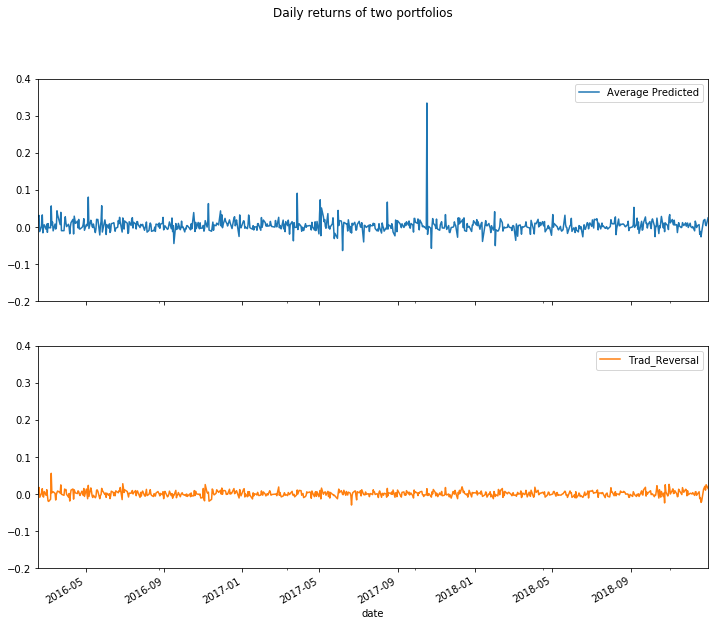

In [63]:
pic.plot(subplots=True, figsize=(12, 10), grid=False, title="Daily returns of two portfolios",ylim=(-0.2,0.4))

In [64]:
pic['Average Predicted'] = pic['Average Predicted'].cumsum()
pic['Average Predicted'] 
pic['Trad__Reversal'] = pic['Trad_Reversal'].cumsum()
pic['Average Predicted']
picture = pic[['Average Predicted','Trad__Reversal']]
picture.head()

,Average Predicted,Trad__Reversal
date,,
2016-02-17,0.028750,0.003431
2016-02-18,0.060145,0.021439
2016-02-19,0.047978,0.012821
2016-02-22,0.050537,0.015545
2016-02-23,0.083371,0.030350


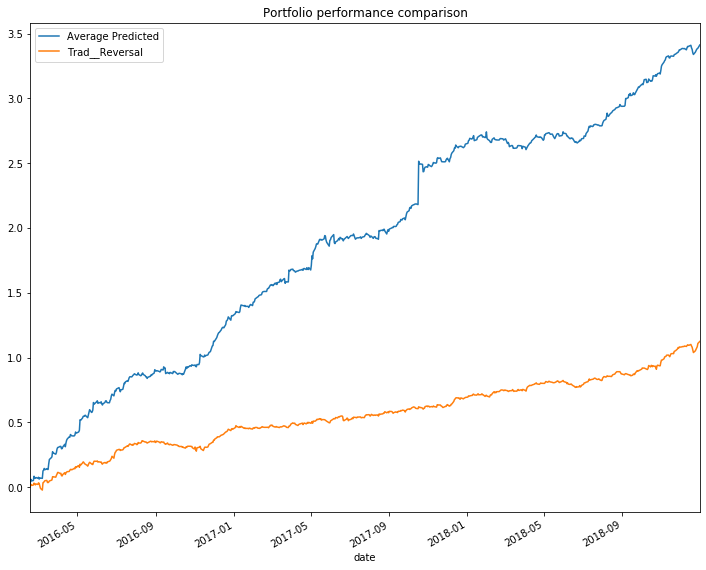

In [65]:
picture.plot(title="Portfolio performance comparison",figsize=(12, 10))

# Compare two methods

### Our strategy gives 0.004726 daily mean return, and the sharpe ratio is 3.88
### Traditional strategy gives 0.001557 daily mean return, and the sharpe ratio is 3.16
### At present, ignore the transaction cost, our strategy looks better

# Analysis of stocks' features

In [66]:
# stocks selected to construct portfolio
res2 = result2[['pred_return','lag1_ret']]
ana_stock = res2.merge(model_stocks[['ob_vola5','ob_vola10','ob_vola15','ob_vola20',
                                     'lag5_TO','lag4_TO','lag3_TO','lag2_TO','lag1_TO','Market_Cap']], 
                       how = 'left', left_index = True, right_index = True)
ana_stock.head()

pred_return  lag1_ret  ob_vola5  ob_vola10  ob_vola15  \
date       PERMNO                                                          
2016-02-17 10001      0.018098     -0.01  0.031623   0.031287   0.025765   
           10025      0.012451     -0.01  0.046043   0.036347   0.040332   
           10116      0.012762     -0.02  0.052631   0.051262   0.045335   
           10158      0.016248     -0.09  0.043932   0.035606   0.035550   
           10232      0.015312     -0.03  0.025495   0.019692   0.021647   

                   ob_vola20   lag5_TO   lag4_TO   lag3_TO   lag2_TO  \
date       PERMNO                                                      
2016-02-17 10001    0.023725  0.837506  1.934983  2.005902  0.923084   
           10025    0.047782  6.316428  3.629332  3.233405  3.659095   
           10116    0.047603  2.675511  0.635119  2.151259  0.695031   
           10158    0.040324  0.611193  1.228838  0.575040  0.680973   
           10232    0.021546  0.088138  0.082262  0.719794  0.076386   

                    lag1_TO  Market_Cap  
date       PERMNO                        
2016-02-17 10001   1.276821    86141.00  
           10025   5.320345   381390.76  
           10116   0.763140    25561.44  
           10158   5.177642   132323.52  
           10232   0.000367    48142.64

In [67]:
# stocks not selected to construct pprtfolio
result3 = result1[result1['pred_return']*result1['lag1_ret']>=0]
res3 = result3[['pred_return','lag1_ret']]
ana_stock1 = res3.merge(model_stocks[['ob_vola5','ob_vola10','ob_vola15','ob_vola20',
                                     'lag5_TO','lag4_TO','lag3_TO','lag2_TO','lag1_TO','Market_Cap']], 
                       how = 'left', left_index = True, right_index = True)
ana_stock1.head()

pred_return  lag1_ret  ob_vola5  ob_vola10  ob_vola15  \
date       PERMNO                                                          
2016-02-17 10026      0.016359      0.01  0.008367   0.010328   0.011255   
           10028      0.007719      0.07  0.078930   0.085088   0.084976   
           10032      0.015979      0.03  0.014832   0.020028   0.019518   
           10044      0.018134      0.10  0.047223   0.035214   0.029081   
           10051      0.016069      0.02  0.021679   0.020028   0.028735   

                   ob_vola20   lag5_TO   lag4_TO   lag3_TO   lag2_TO  \
date       PERMNO                                                      
2016-02-17 10026    0.011910  3.586642  2.987638  2.142941  3.622605   
           10028    0.086414  4.719421  1.397284  2.945673  1.692095   
           10032    0.034101  4.324434  4.644075  3.476105  3.646022   
           10044    0.028544  1.173317  1.513444  1.711766  1.063024   
           10051    0.026651  2.856451  3.771160  2.672608  3.735343   

                    lag1_TO  Market_Cap  
date       PERMNO                        
2016-02-17 10026   3.185861  2014911.38  
           10028   3.996584     7623.52  
           10032   5.580914  1212847.50  
           10044   3.546840    62418.91  
           10051   8.359837   422080.36

### previous 5 days volatility (selected)

In [68]:
ana_stock['QUINTILE_vola5'] = ana_stock['ob_vola5'].groupby('date').apply(quintiles)

In [69]:
ana_vola5 = ana_stock.groupby(['QUINTILE_vola5','PERMNO'])['ob_vola5'].mean()
ana_vola5.dropna(inplace = True)
ana_vola5.head()

QUINTILE_vola5  PERMNO
1               10001     0.008806
                10025     0.007850
                10026     0.010349
                10028     0.011690
                10032     0.010627
Name: ob_vola5, dtype: float64

In [70]:
ana_vola5.groupby(['QUINTILE_vola5']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola5,,,,,,,,
1,1771.0,0.011276,0.002306,0.004472,0.009931,0.010859,0.012229,0.024453
2,1763.0,0.018208,0.002783,0.012526,0.016443,0.017518,0.019176,0.037417
3,1772.0,0.024987,0.003430,0.010991,0.022909,0.024488,0.026116,0.046152
4,1742.0,0.034941,0.004771,0.015166,0.032272,0.034750,0.036719,0.067602
5,1617.0,0.070029,0.035508,0.024900,0.054654,0.063478,0.075953,0.750898


### previous 5 days volatility (un-selected)

In [71]:
ana_stock1['QUINTILE_vola5_un'] = ana_stock1['ob_vola5'].groupby('date').apply(quintiles)
ana_vola5_unselected = ana_stock1.groupby(['QUINTILE_vola5_un','PERMNO'])['ob_vola5'].mean()
ana_vola5_unselected.dropna(inplace = True)
ana_vola5_unselected.groupby(['QUINTILE_vola5_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola5_un,,,,,,,,
1,1740.0,0.007621,0.002857,0.000000,0.006505,0.007378,0.008750,0.023875
2,1772.0,0.013504,0.002530,0.004472,0.011975,0.012848,0.014407,0.035635
3,1786.0,0.019136,0.003094,0.010000,0.017317,0.018387,0.020156,0.044385
4,1782.0,0.027250,0.003883,0.013038,0.025099,0.026836,0.028744,0.056745
5,1749.0,0.056346,0.028215,0.012247,0.043855,0.050651,0.060055,0.465014


### previous 10 days volatility (selected)

In [72]:
ana_stock['QUINTILE_vola10'] = ana_stock['ob_vola10'].groupby('date').apply(quintiles)
ana_vola10 = ana_stock.groupby(['QUINTILE_vola10','PERMNO'])['ob_vola10'].mean()
ana_vola10.dropna(inplace = True)
ana_vola10.groupby(['QUINTILE_vola10']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola10,,,,,,,,
1,1685.0,0.013801,0.003805,0.003162,0.011616,0.013004,0.015317,0.036271
2,1733.0,0.020112,0.003282,0.009944,0.017869,0.019343,0.021667,0.041753
3,1745.0,0.026469,0.003684,0.015333,0.024044,0.026040,0.028284,0.046164
4,1674.0,0.036039,0.004959,0.014298,0.033148,0.035998,0.038263,0.064083
5,1471.0,0.067909,0.033123,0.030111,0.052156,0.061397,0.073034,0.634480


### previous 10 days volatility (un-selected)

In [73]:
ana_stock1['QUINTILE_vola10_un'] = ana_stock1['ob_vola10'].groupby('date').apply(quintiles)
ana_vola10_unselected = ana_stock1.groupby(['QUINTILE_vola10_un','PERMNO'])['ob_vola10'].mean()
ana_vola10_unselected.dropna(inplace = True)
ana_vola10_unselected.groupby(['QUINTILE_vola10_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola10_un,,,,,,,,
1,1594.0,0.011003,0.005108,0.000000,0.008779,0.010140,0.012573,0.038224
2,1723.0,0.016413,0.003787,0.003162,0.014118,0.015223,0.017611,0.044833
3,1755.0,0.021748,0.003856,0.010512,0.019477,0.020784,0.023198,0.062013
4,1752.0,0.029584,0.004438,0.012994,0.027139,0.029257,0.031386,0.056572
5,1641.0,0.057577,0.030254,0.015492,0.044596,0.051662,0.061052,0.472371


### previous 15 days volatility (selected)

In [74]:
ana_stock['QUINTILE_vola15'] = ana_stock['ob_vola15'].groupby('date').apply(quintiles)
ana_vola15 = ana_stock.groupby(['QUINTILE_vola15','PERMNO'])['ob_vola15'].mean()
ana_vola15.dropna(inplace = True)
ana_vola15.groupby(['QUINTILE_vola15']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola15,,,,,,,,
1,1595.0,0.015085,0.004759,0.002582,0.012330,0.014074,0.017012,0.046578
2,1719.0,0.021206,0.003733,0.012786,0.018536,0.020346,0.023233,0.041092
3,1724.0,0.027324,0.004112,0.010601,0.024640,0.026964,0.029442,0.047339
4,1605.0,0.036630,0.005094,0.013452,0.033936,0.036739,0.039102,0.063185
5,1369.0,0.067688,0.035499,0.028486,0.051671,0.060186,0.072952,0.668359


### previous 15 days volatility (un-selected)

In [75]:
ana_stock1['QUINTILE_vola15_un'] = ana_stock1['ob_vola10'].groupby('date').apply(quintiles)
ana_vola15_unselected = ana_stock1.groupby(['QUINTILE_vola15_un','PERMNO'])['ob_vola10'].mean()
ana_vola15_unselected.dropna(inplace = True)
ana_vola15_unselected.groupby(['QUINTILE_vola15_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola15_un,,,,,,,,
1,1594.0,0.011003,0.005108,0.000000,0.008779,0.010140,0.012573,0.038224
2,1723.0,0.016413,0.003787,0.003162,0.014118,0.015223,0.017611,0.044833
3,1755.0,0.021748,0.003856,0.010512,0.019477,0.020784,0.023198,0.062013
4,1752.0,0.029584,0.004438,0.012994,0.027139,0.029257,0.031386,0.056572
5,1641.0,0.057577,0.030254,0.015492,0.044596,0.051662,0.061052,0.472371


### previous 20 days volatility (selected)

In [76]:
ana_stock['QUINTILE_vola20'] = ana_stock['ob_vola20'].groupby('date').apply(quintiles)
ana_vola20 = ana_stock.groupby(['QUINTILE_vola20','PERMNO'])['ob_vola20'].mean()
ana_vola20.dropna(inplace = True)
ana_vola20.groupby(['QUINTILE_vola20']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola20,,,,,,,,
1,1535.0,0.015763,0.005142,0.002236,0.012797,0.014648,0.017940,0.043682
2,1693.0,0.021875,0.003976,0.011638,0.019061,0.020953,0.024115,0.040880
3,1697.0,0.027938,0.004368,0.011459,0.025136,0.027565,0.030291,0.051430
4,1542.0,0.037217,0.005366,0.014290,0.034476,0.037436,0.039784,0.066285
5,1307.0,0.067334,0.037774,0.028580,0.051003,0.059319,0.072561,0.603653


### previous 20 days volatility (un-selected)

In [77]:
ana_stock1['QUINTILE_vola20_un'] = ana_stock1['ob_vola20'].groupby('date').apply(quintiles)
ana_vola20_unselected = ana_stock1.groupby(['QUINTILE_vola20_un','PERMNO'])['ob_vola20'].mean()
ana_vola20_unselected.dropna(inplace = True)
ana_vola20_unselected.groupby(['QUINTILE_vola20_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_vola20_un,,,,,,,,
1,1404.0,0.013469,0.007028,0.000000,0.010236,0.012027,0.015648,0.062818
2,1634.0,0.019257,0.005675,0.005104,0.015771,0.017034,0.020903,0.051552
3,1726.0,0.023886,0.004667,0.010894,0.021111,0.022778,0.025852,0.063335
4,1702.0,0.031480,0.005738,0.011653,0.028937,0.031483,0.033875,0.068776
5,1492.0,0.057961,0.032635,0.017137,0.043828,0.051470,0.062229,0.449450


### 5 days before Turn Over (selected)

In [78]:
ana_stock['QUINTILE_TO5'] = ana_stock['lag5_TO'].groupby('date').apply(quintiles)
ana_TO5 = ana_stock.groupby(['QUINTILE_TO5','PERMNO'])['lag5_TO'].mean()
ana_TO5.dropna(inplace = True)
ana_TO5.groupby(['QUINTILE_TO5']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO5,,,,,,,,
1,1350.0,1.426432,0.836436,0.000906,0.918246,1.351266,1.803500,6.868555
2,1638.0,3.249085,0.840432,1.138467,2.770951,3.139414,3.574198,13.971796
3,1698.0,5.676369,1.096707,2.183356,5.173432,5.552228,5.966023,18.144340
4,1683.0,9.712305,1.789972,3.507171,8.857162,9.547126,10.275400,37.332108
5,1595.0,35.882337,39.443450,7.535504,19.559476,24.327464,34.854777,733.513621


### 5 days before Turn Over (un-selected)

In [79]:
ana_stock1['QUINTILE_TO5_un'] = ana_stock1['lag5_TO'].groupby('date').apply(quintiles)
ana_TO5_unselected = ana_stock1.groupby(['QUINTILE_TO5_un','PERMNO'])['lag5_TO'].mean()
ana_TO5_unselected.dropna(inplace = True)
ana_TO5_unselected.groupby(['QUINTILE_TO5_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO5_un,,,,,,,,
1,1321.0,1.224306,0.575257,0.024406,0.847346,1.226725,1.578309,4.314073
2,1674.0,3.067166,0.779736,0.612245,2.676956,2.950170,3.312268,14.539062
3,1749.0,5.407275,1.179058,3.002216,4.980890,5.254316,5.597299,29.968175
4,1753.0,9.078204,2.021223,2.918092,8.296180,8.770326,9.350627,36.605880
5,1706.0,32.780419,38.656366,9.010149,18.011146,22.414254,31.344766,737.209134


### 4 days before Turn Over (selected)

In [80]:
ana_stock['QUINTILE_TO4'] = ana_stock['lag4_TO'].groupby('date').apply(quintiles)
ana_TO4 = ana_stock.groupby(['QUINTILE_TO4','PERMNO'])['lag4_TO'].mean()
ana_TO4.dropna(inplace = True)
ana_TO4.groupby(['QUINTILE_TO4']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO4,,,,,,,,
1,1357.0,1.403485,0.797440,0.000000,0.904725,1.352943,1.786819,8.038766
2,1636.0,3.216769,0.884275,0.625360,2.743691,3.102112,3.556584,15.761749
3,1717.0,5.673743,1.268909,1.696250,5.164587,5.538181,5.939123,25.322227
4,1673.0,9.733226,1.809565,4.926955,8.904380,9.518023,10.221370,37.332108
5,1582.0,36.513959,48.010955,5.295659,19.507697,24.465240,35.227533,1219.062614


### 4 days before Turn Over (un-selected)

In [81]:
ana_stock1['QUINTILE_TO4_un'] = ana_stock1['lag4_TO'].groupby('date').apply(quintiles)
ana_TO4_unselected = ana_stock1.groupby(['QUINTILE_TO4_un','PERMNO'])['lag4_TO'].mean()
ana_TO4_unselected.dropna(inplace = True)
ana_TO4_unselected.groupby(['QUINTILE_TO4_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO4_un,,,,,,,,
1,1320.0,1.238991,0.624816,0.020269,0.848070,1.242564,1.582140,7.249770
2,1669.0,3.053559,0.683655,0.745646,2.684428,2.965063,3.300242,16.448770
3,1744.0,5.418694,1.197541,2.925231,4.984982,5.266481,5.599959,28.097958
4,1752.0,9.086494,1.987321,4.622682,8.267050,8.779462,9.403593,35.702326
5,1707.0,33.046372,38.274820,9.182263,17.772290,22.475803,31.678408,639.156450


### 3 days before Turn Over (selected)

In [82]:
ana_stock['QUINTILE_TO3'] = ana_stock['lag3_TO'].groupby('date').apply(quintiles)
ana_TO3 = ana_stock.groupby(['QUINTILE_TO3','PERMNO'])['lag3_TO'].mean()
ana_TO3.dropna(inplace = True)
ana_TO3.groupby(['QUINTILE_TO3']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO3,,,,,,,,
1,1338.0,1.423214,0.816227,0.000000,0.921499,1.371792,1.799489,8.081996
2,1632.0,3.266714,0.874328,0.414904,2.788619,3.156564,3.588007,14.588496
3,1699.0,5.731821,1.092261,2.422005,5.230852,5.633501,6.022248,19.496988
4,1686.0,9.954035,2.774535,3.487851,8.974367,9.651660,10.359798,56.061395
5,1585.0,35.967255,41.952510,5.509851,19.713845,24.586863,34.934428,985.429112


### 3 days before Turn Over (un-selected)

In [83]:
ana_stock1['QUINTILE_TO3_un'] = ana_stock1['lag3_TO'].groupby('date').apply(quintiles)
ana_TO3_unselected = ana_stock1.groupby(['QUINTILE_TO3_un','PERMNO'])['lag3_TO'].mean()
ana_TO3_unselected.dropna(inplace = True)
ana_TO3_unselected.groupby(['QUINTILE_TO3_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO3_un,,,,,,,,
1,1328.0,1.236488,0.602853,0.021124,0.864487,1.246208,1.584643,7.408932
2,1668.0,3.031460,0.581001,0.717102,2.684914,2.954490,3.288109,7.953281
3,1746.0,5.365759,1.015580,1.988372,4.977450,5.230970,5.535742,26.749343
4,1757.0,9.000104,2.621679,2.918092,8.237089,8.727779,9.346612,92.928642
5,1700.0,32.880340,42.143769,7.381149,17.684916,22.167200,31.289604,898.473815


### 2 days before Turn Over (selected)

In [84]:
ana_stock['QUINTILE_TO2'] = ana_stock['lag2_TO'].groupby('date').apply(quintiles)
ana_TO2 = ana_stock.groupby(['QUINTILE_TO2','PERMNO'])['lag2_TO'].mean()
ana_TO2.dropna(inplace = True)
ana_TO2.groupby(['QUINTILE_TO2']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO2,,,,,,,,
1,1344.0,1.365062,0.717003,0.000000,0.908376,1.337697,1.765979,6.315568
2,1640.0,3.221192,0.933549,0.892319,2.766696,3.127475,3.537031,23.985085
3,1722.0,5.721658,1.177501,1.743104,5.231398,5.605371,6.027972,25.322227
4,1669.0,9.873548,2.260589,2.918092,8.950033,9.641486,10.366465,53.165270
5,1572.0,35.282581,37.772399,5.723369,19.265803,24.597297,34.481944,804.364967


### 2 days before Turn Over (un-selected)

In [85]:
ana_stock1['QUINTILE_TO2_un'] = ana_stock1['lag2_TO'].groupby('date').apply(quintiles)
ana_TO2_unselected = ana_stock1.groupby(['QUINTILE_TO2_un','PERMNO'])['lag2_TO'].mean()
ana_TO2_unselected.dropna(inplace = True)
ana_TO2_unselected.groupby(['QUINTILE_TO2_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO2_un,,,,,,,,
1,1335.0,1.266094,0.654679,0.012182,0.883503,1.259235,1.615485,8.536383
2,1661.0,3.078325,0.639832,0.383474,2.711142,2.973723,3.346131,11.436468
3,1746.0,5.425686,1.405972,1.332665,4.981812,5.266633,5.608717,37.642376
4,1753.0,9.100577,2.209986,2.968752,8.282916,8.780118,9.400170,52.782354
5,1709.0,35.139004,46.809463,7.368808,18.106189,22.605757,32.915424,978.876919


### 1 days before Turn Over (selected)

In [86]:
ana_stock['QUINTILE_TO1'] = ana_stock['lag1_TO'].groupby('date').apply(quintiles)
ana_TO1 = ana_stock.groupby(['QUINTILE_TO1','PERMNO'])['lag1_TO'].mean()
ana_TO1.dropna(inplace = True)
ana_TO1.groupby(['QUINTILE_TO1']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO1,,,,,,,,
1,1331.0,1.383662,0.687130,0.000000,0.941006,1.356728,1.804595,9.379060
2,1637.0,3.283768,0.740919,0.688990,2.843221,3.197019,3.604043,13.426180
3,1706.0,5.822461,1.040409,2.248544,5.383205,5.716082,6.112419,21.591000
4,1690.0,10.155690,2.076118,2.833312,9.213198,9.875206,10.645485,37.332108
5,1598.0,42.490557,55.163027,8.275006,20.994210,26.901025,38.965202,1030.809678


### 1 days before Turn Over (un-selected)

In [87]:
ana_stock1['QUINTILE_TO1_un'] = ana_stock1['lag1_TO'].groupby('date').apply(quintiles)
ana_TO1_unselected = ana_stock1.groupby(['QUINTILE_TO1_un','PERMNO'])['lag1_TO'].mean()
ana_TO1_unselected.dropna(inplace = True)
ana_TO1_unselected.groupby(['QUINTILE_TO1_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_TO1_un,,,,,,,,
1,1334.0,1.274257,0.692587,0.000000,0.860945,1.250074,1.618667,6.655947
2,1655.0,3.080250,0.668164,0.929832,2.693332,2.981139,3.351951,10.682564
3,1747.0,5.455163,1.277472,1.587008,4.973269,5.269793,5.615601,33.543171
4,1748.0,9.135821,3.326035,4.951204,8.226903,8.757691,9.400604,116.246003
5,1716.0,30.593215,32.856109,4.705644,17.471817,21.889651,30.316940,664.895453


### Market Cap (selected)

In [88]:
ana_stock['QUINTILE_MC'] = ana_stock['Market_Cap'].groupby('date').apply(quintiles)
ana_MC = ana_stock.groupby(['QUINTILE_MC','PERMNO'])['Market_Cap'].mean()
ana_MC.dropna(inplace = True)
ana_MC.groupby(['QUINTILE_MC']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_MC,,,,,,,,
1,719.0,7.125012e+04,4.865526e+04,4236.118089,3.203925e+04,6.080345e+04,1.018814e+05,4.351788e+05
2,1084.0,3.101824e+05,1.081434e+06,18305.340000,8.981877e+04,1.738721e+05,3.034498e+05,1.535446e+07
3,1275.0,7.587598e+05,1.959420e+06,40341.700000,1.916109e+05,4.077896e+05,7.085931e+05,2.186192e+07
4,1264.0,2.137042e+06,9.381405e+06,89909.730000,3.937661e+05,8.358247e+05,1.689783e+06,2.135621e+08
5,902.0,1.155126e+07,4.642796e+07,211201.200000,1.132278e+06,2.062021e+06,4.428994e+06,7.766221e+08


### Market Cap (un-selected)

In [89]:
ana_stock1['QUINTILE_MC_un'] = ana_stock1['Market_Cap'].groupby('date').apply(quintiles)
ana_MC_unselected = ana_stock1.groupby(['QUINTILE_MC_un','PERMNO'])['Market_Cap'].mean()
ana_MC_unselected.dropna(inplace = True)
ana_MC_unselected.groupby(['QUINTILE_MC_un']).describe()

,count,mean,std,min,25%,50%,75%,max
QUINTILE_MC_un,,,,,,,,
1,766.0,9.783727e+04,2.323927e+05,4116.738469,3.762938e+04,6.954937e+04,1.088589e+05,4.807999e+06
2,1204.0,1.274542e+06,8.700220e+06,14474.190000,1.261353e+05,2.262831e+05,3.719492e+05,1.418453e+08
3,1444.0,3.125575e+06,1.322842e+07,28203.960000,2.613655e+05,5.888923e+05,1.104484e+06,1.916222e+08
4,1267.0,6.485212e+06,2.523820e+07,100377.690000,5.221542e+05,1.229801e+06,2.356336e+06,3.438423e+08
5,815.0,1.280912e+07,4.829993e+07,264890.040000,1.332110e+06,2.441663e+06,5.041976e+06,7.579329e+08
